In [1]:
!pip install tokenizers
import tensorflow as tf
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, Regex
import tokenizers
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 10.9 MB/s eta 0:00:0000:0100:01


2023-05-07 18:56:25.058181: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.__version__

'2.11.0'

In [4]:
model_name = 'lstm_attention'

# Load data

In [5]:
df = pd.read_csv('/home/user/files_for_research_Vova/processed_data.csv', usecols=['review_translate',
                                                            'dataset_name',
                                                            'rating',
                                                           'translated'])

In [6]:
df.head()

,review_translate,rating,dataset_name,translated
0,"Якісна пластмаса , переворот 360 градусвв",5.0,rozetka,False
1,За такі гроші це самий топ,5.0,rozetka,False
2,За такі гроші - просто супер ! Рекомендую .,5.0,rozetka,False
3,Виконує свою роботу не погано . але що ви хоті...,4.0,rozetka,False
4,Купляв на стару сістему як основний під віндов...,4.0,rozetka,False


In [7]:
subsets = pd.read_csv('/home/user/files_for_research_Vova/train_val_test_indices.csv')

In [8]:
subsets.head()

,index,split
0,0,train
1,1,test
2,2,train
3,3,train
4,4,train


In [9]:
subsets = subsets.merge(df[['dataset_name', 'translated']], left_on='index', right_index=True)

In [10]:
bad_indices = pd.read_csv('/home/user/files_for_research_Vova/files_to_check.csv')
subsets = subsets[~subsets.index.isin(bad_indices['id'].values)]
df = df[~df.index.isin(bad_indices['id'].values)]
df, subsets = df.reset_index().drop(columns='index'), subsets.reset_index().drop(columns='index')

# Load tokenizer

In [11]:
tokenizer = Tokenizer.from_file("/home/user/files_for_research_Vova/tokenizer_30k.json")


# Encode text

In [12]:
import seaborn as sns
import numpy as np

In [13]:
sns.set()

In [14]:
df['review_translate'] = df['review_translate'].str.lower()

In [15]:
df['encoded'] = tokenizer.encode_batch(df['review_translate'].values)

In [16]:
df['encoded'] = df['encoded'].apply(lambda x: x.ids)

/tmp/ipykernel_1/3749403729.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log10(df['encoded'].apply(len)))


<AxesSubplot: xlabel='encoded', ylabel='Density'>

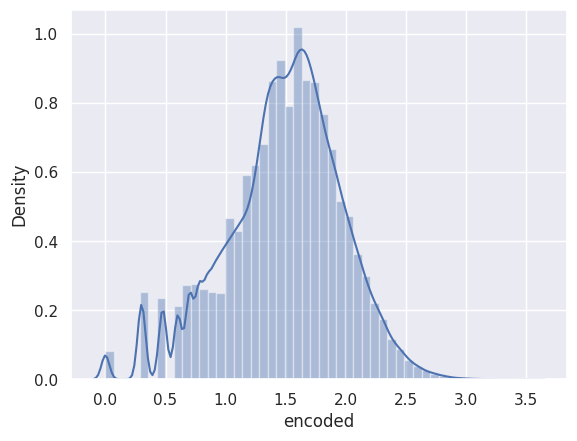

In [17]:
sns.distplot(np.log10(df['encoded'].apply(len)))

In [18]:
np.percentile(df['encoded'].apply(len), 99)

324.0

In [19]:
encoded_tokens = df['encoded'].values

In [20]:
from itertools import chain

In [21]:
padded_tokens = tf.keras.preprocessing.sequence\
.pad_sequences(encoded_tokens, maxlen=300, padding="post")


In [22]:
padded_tokens.shape

(655470, 300)

# Get labels and split data

In [23]:
mapping = dict([(i,c) for c,i in enumerate(df['rating'].unique())])

In [24]:
y = df['rating'].map(mapping).values

In [25]:
num_classes = len(set(y))

In [26]:
train_indices, val_indices, test_indices = subsets[subsets['split']=='train'].index.tolist(),\
subsets[subsets['split']=='val'].index.tolist(),\
subsets[subsets['split']=='test'].index.tolist()


In [27]:
train_y, val_y, test_y = y[train_indices], y[val_indices], y[test_indices]

In [28]:
train_x, val_x, test_x = padded_tokens[train_indices], padded_tokens[val_indices],\
padded_tokens[test_indices]

In [29]:
train_x.shape

(524346, 300)

# Create  model

In [30]:
class Attention(tf.keras.layers.Layer):
    def __init__(self,  
                 units=128, **kwargs):
        super(Attention,self).__init__(**kwargs)
        self.units = units
    
    def build(self, input_shape):
        self.W1=self.add_weight(name='attention_weights_1', shape=(input_shape[-1], self.units), 
                               initializer='glorot_uniform', trainable=True)
        
        self.W2=self.add_weight(name='attention_weights_2', shape=(1, self.units), 
                               initializer='glorot_uniform', trainable=True) 
        
        super(Attention, self).build(input_shape)
        
    def call(self, x):
        x = tf.transpose(x, perm=[0, 2, 1])
        attention = tf.nn.softmax(tf.matmul(self.W2, tf.nn.tanh(tf.matmul(self.W1, x))))
        weighted_context = tf.reduce_sum(x * attention, axis=-1)
        return weighted_context, attention
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'units': self.units
        })
        return config


In [58]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
# define layers
attention = Attention(units=128, name='attention')
input_layer = tf.keras.layers.Input(shape=(300,), name='input')
word_embedding = tf.keras.layers.Embedding(input_dim=tokenizer.get_vocab_size(),
                                                   output_dim=300,
                                                   trainable=True,
                                           name='embedding',
                                           mask_zero=True
                                                   )
spatial_dropout = tf.keras.layers.SpatialDropout1D(0.3, name='spatial_dropout')
lstm = tf.keras.layers.LSTM(128, name='lstm',
                            return_sequences=True, return_state=True,)
dense1 = tf.keras.layers.Dense(128, activation='relu', name='dense')
dropout = tf.keras.layers.Dropout(0.5, name='dropout')
logits_layer = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')

#actual flow
embedded = spatial_dropout(word_embedding(input_layer))
context_vector, state_h, _ = lstm(embedded)
weighted_context, attention_scores = attention(context_vector)
final_attn_output = tf.concat([state_h, weighted_context], axis=1)
x = dense1(final_attn_output)
x = dropout(x)
x = logits_layer(x)
model = tf.keras.Model(input_layer, x)

# Compile model

In [59]:
model.compile(loss='sparse_categorical_crossentropy', \
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

# Early stopping

In [60]:
import operator
class EarlyStopping:
    def __init__(self, tolerance=5, mode='min'):
        assert mode in ['min','max'], 'Mode should be min or max'
        self.mode = operator.lt if mode=='min' else operator.gt 
        self.tolerance = tolerance
        self.counter = 0
        self.early_stop = False
        self.extremum_value = None
        self.best_model = None
    
    @staticmethod
    def copy_model(model):
        copied_model = tf.keras.models.clone_model(model)
        copied_model.set_weights(model.get_weights())
        return copied_model
        
    def __call__(self, val, model):
        if self.extremum_value is None:
            self.extremum_value = val
            self.best_model = self.copy_model(model)
        else:
            if not self.mode(val, self.extremum_value):
                self.counter+=1
            else:
                self.extremum_value = val
                self.best_model = self.copy_model(model)
                self.counter = 0
        
        if self.counter==self.tolerance:
            self.early_stop=True

# Train model

In [61]:
from sklearn.metrics import f1_score

In [62]:
def evaluate_on_datasets(y_true, y_pred, split='val'):
    d = {}
    for dataset_name in subsets['dataset_name'].unique():
            idx = subsets[subsets['split']==split].copy()
            idx['index'] = list(range(idx.shape[0]))
            idx = idx[(idx['dataset_name']==dataset_name)]\
            ['index'].values.tolist()
            score = f1_score(y_true=y_true[idx], y_pred=y_pred[idx],
                                 average='macro')
            print(f'{split} f1 score for dataset {dataset_name} : {score}')
            d[f'{split}_f1_{dataset_name}'] = score
            
    for flag in [True, False]:
        idx = subsets[subsets['split']==split].copy()
        idx['index'] = list(range(idx.shape[0]))
        idx = idx[idx['translated']==flag]['index'].values.tolist()
        score = f1_score(y_true=y_true[idx], y_pred=y_pred[idx],
                                 average='macro')
        print(f'{split} f1 score for translated=={flag} : {score}')
        d[f'{split}_f1_translated=={flag}'] = score
    return d

In [63]:
def update_history(history, d):
    for key, value in d.items():
        res = history.get(key, [])
        res.append(value)
        history[key] = res

In [64]:
early_stopping = EarlyStopping(mode='max', tolerance=4)

In [65]:
def training_loop(model, epochs=10, batch_size=128):
    dict_history = {}
    for i in range(epochs):
        
        #train model
        history = model.fit(train_x, train_y, validation_data=(val_x, val_y), 
          epochs=1, batch_size=batch_size,
                           verbose=0)
        train_loss, val_loss = history.history['loss'][-1], history.history['val_loss'][-1]
        
        #evaluate model
        train_prediction = np.argmax(model.predict(train_x, batch_size=2048), axis=-1)
        val_prediction = np.argmax(model.predict(val_x,batch_size=2048), axis=-1)
        train_f1 = f1_score(y_true=train_y, y_pred=train_prediction,
                           average='macro')
        val_f1 = f1_score(y_true=val_y, y_pred=val_prediction,
                         average='macro')
        
        #printing evaluation
        print(f'Epoch {i}')
        print(f'Overall train f1 : {train_f1}, overall val f1: {val_f1}')
        print(f'Train loss : {train_loss}, val loss: {val_loss}')
        d_train = evaluate_on_datasets(y_true=train_y, y_pred=train_prediction, split='train')
        d_val = evaluate_on_datasets(y_true=val_y, y_pred=val_prediction, split='val')
            
        if i!=epochs-1:
            print('-'*30)
            
        #save history
        update_history(dict_history, d_train)
        update_history(dict_history, d_val)
        update_history(dict_history, {'train_f1': train_f1})
        update_history(dict_history, {'val_f1': val_f1})
        update_history(dict_history, {'train_loss': train_loss})
        update_history(dict_history, {'val_loss': val_loss})
        #early stopping
        
        early_stopping(val_f1, model)
        if early_stopping.early_stop:
            print('Stopping early')
            model = early_stopping.best_model
            break
        
    return dict_history, model

In [66]:
dict_history, model = \
training_loop(model, epochs=20, batch_size=2048)

2023-05-07 19:45:56.723369: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA RTX A4000" frequency: 1560 num_cores: 48 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "8700" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 102400 memory_size: 14835253248 bandwidth: 448064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-05-07 19:45:57.571102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-05-07 19:46:56.252960: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dt

33/33 [==============================] - 1s 30ms/step
Epoch 0
Overall train f1 : 0.4836498481702807, overall val f1: 0.46346816367241395
Train loss : 0.794343888759613, val loss: 0.6571950316429138
train f1 score for dataset rozetka : 0.41762110594381785
train f1 score for dataset tripadvisor_hotels_ukraine : 0.5304956422425356
train f1 score for dataset tripadvisor_restaurants_ukraine : 0.5277653402737463
train f1 score for translated==True : 0.4931495420061435
train f1 score for translated==False : 0.4111325315640871
val f1 score for dataset rozetka : 0.39956854596926744
val f1 score for dataset tripadvisor_hotels_ukraine : 0.5156319386880414
val f1 score for dataset tripadvisor_restaurants_ukraine : 0.5027090987111965
val f1 score for translated==True : 0.471983874684805
val f1 score for translated==False : 0.3974284436545906
------------------------------
33/33 [==============================] - 1s 30ms/step
Epoch 1
Overall train f1 : 0.5295714568888082, overall val f1: 0.486010746

In [67]:
dict_history

{'train_f1_rozetka': [0.41762110594381785,
  0.4726330855975168,
  0.4935064819341465,
  0.555026085613655,
  0.6009914352729598,
  0.6338900526772338,
  0.6551511429761009,
  0.7004250592686675,
  0.7203679445807457],
 'train_f1_tripadvisor_hotels_ukraine': [0.5304956422425356,
  0.5620428766121272,
  0.5720842745405434,
  0.6288123521675553,
  0.6683680752523625,
  0.6984920665091644,
  0.6934573857451655,
  0.7373658842484337,
  0.7639418370996405],
 'train_f1_tripadvisor_restaurants_ukraine': [0.5277653402737463,
  0.5709242142181807,
  0.5810113290349567,
  0.6377411011291628,
  0.6788982431448518,
  0.7000077605939001,
  0.7065195587024584,
  0.7429377608394749,
  0.7634102046218522],
 'train_f1_translated==True': [0.4931495420061435,
  0.5369577815001932,
  0.5499290196008908,
  0.6070743632923282,
  0.6494557431464228,
  0.6767619248221629,
  0.6861896025920594,
  0.7271525199830251,
  0.7481023213418],
 'train_f1_translated==False': [0.4111325315640871,
  0.4740830096085552,
 

# Show charts

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
def plot_history(dict_history, columns):
    plt.figure(figsize=(12,8))
    for i in columns:
        to_plot = dict_history[i]
        plt.plot(range(len(to_plot)), to_plot, 'o-')
    plt.xticks(range(len(to_plot)), range(len(to_plot)))
    plt.xlabel('Epochs')
    plt.legend(columns)

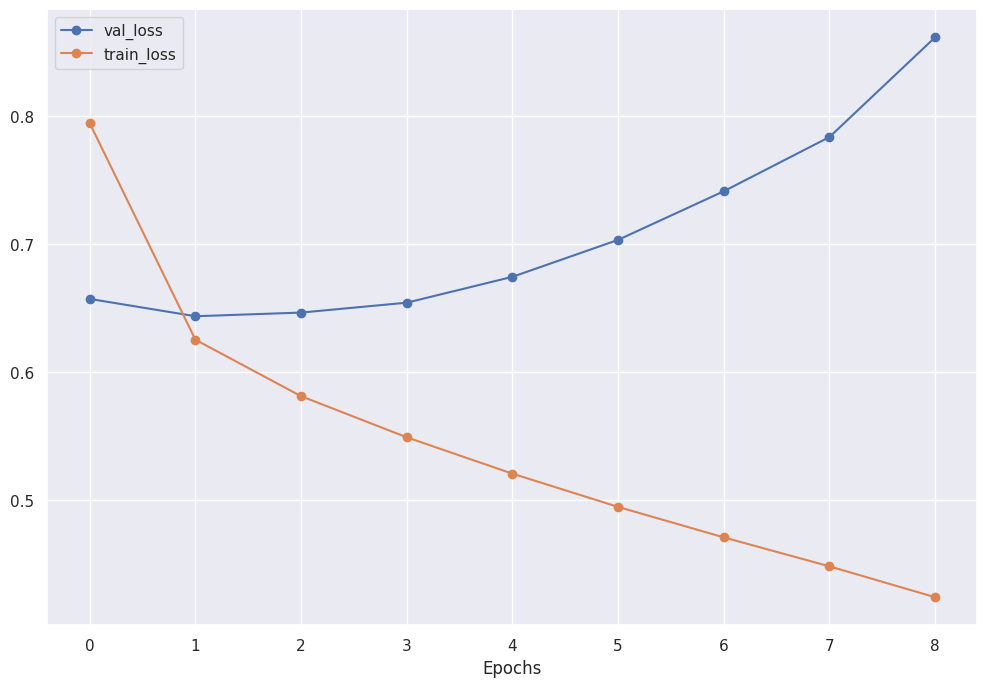

In [70]:
plot_history(dict_history, ['val_loss', 'train_loss'])

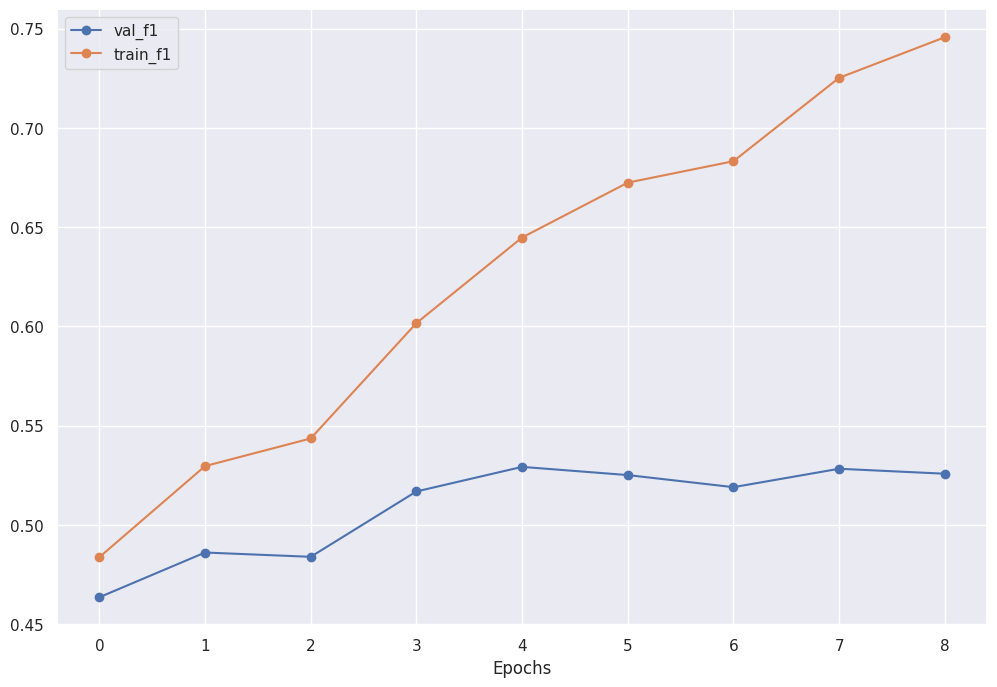

In [71]:
plot_history(dict_history, ['val_f1', 'train_f1'])

# Evaluate model

In [72]:
test_predictions = np.argmax(model.predict(test_x, batch_size=2048), axis=-1)

2023-05-07 19:53:11.101864: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA RTX A4000" frequency: 1560 num_cores: 48 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "8700" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 102400 memory_size: 14835253248 bandwidth: 448064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


33/33 [==============================] - 2s 30ms/step


In [73]:
test_f1 = f1_score(y_true=test_y, y_pred=test_predictions,
                         average='macro')
print(f'Overall test f1-score : {test_f1}')

Overall test f1-score : 0.5257559720081815


In [74]:
test_results = evaluate_on_datasets(y_true=test_y, y_pred=test_predictions,split='test')
                     

test f1 score for dataset rozetka : 0.4747725836518952
test f1 score for dataset tripadvisor_hotels_ukraine : 0.5558080306121199
test f1 score for dataset tripadvisor_restaurants_ukraine : 0.5639159363279109
test f1 score for translated==True : 0.5309177070773291
test f1 score for translated==False : 0.4838446831400094


# Confusion matrix

In [75]:
from sklearn.metrics import confusion_matrix

In [76]:
np.unique(test_y)

array([0, 1, 2, 3, 4])

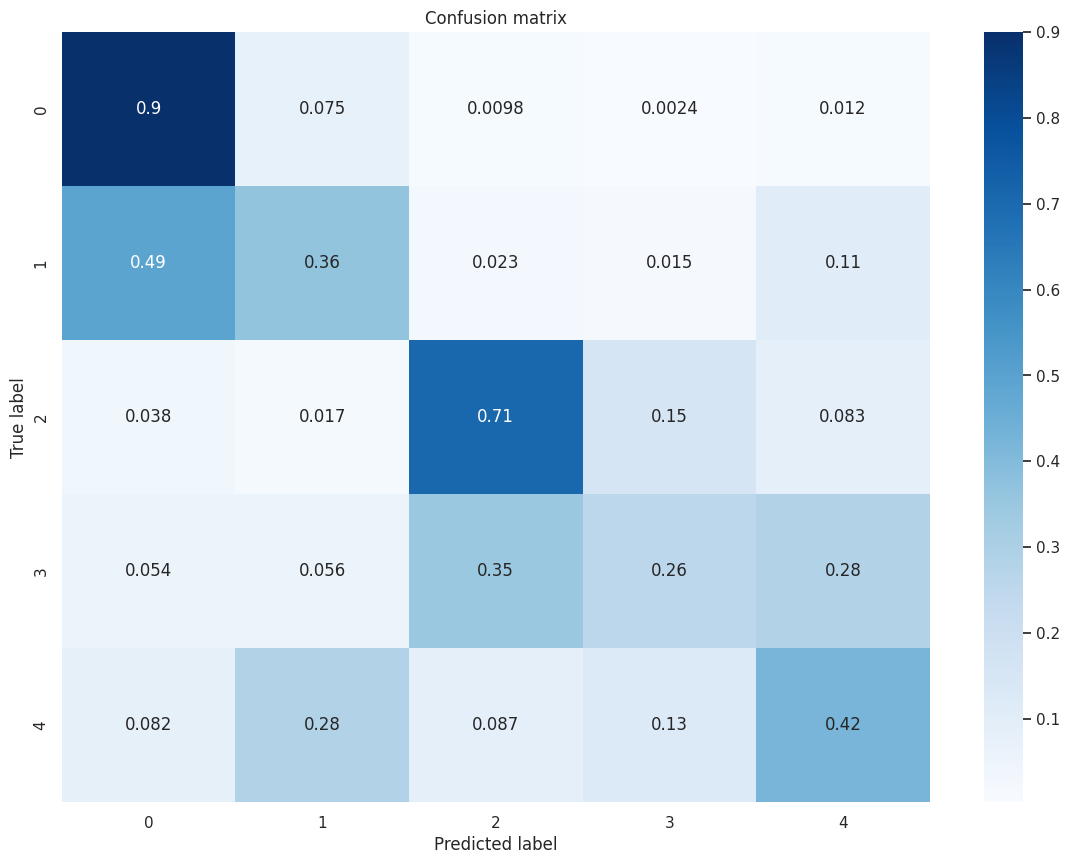

In [77]:
matrix = confusion_matrix(test_y, test_predictions)
matrix_scaled = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14,10))
sns.heatmap(matrix_scaled, annot=True, cmap=plt.cm.Blues, xticklabels=np.unique(test_y),\
            yticklabels=np.unique(test_y))
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()

# Save history results

In [78]:
history = pd.DataFrame(dict_history)
for k,v in test_results.items():
    history[k] = v

In [79]:
history['model'] = model_name

In [80]:
history.to_csv("/home/user/jupyter_notebooks/Ukranian-SA/notebooks/training/training_results_filtered.csv", mode='a', header=None, index=None)

In [81]:
model.save(f'/home/user/files_for_research_Vova/{model_name}.h5')